In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures

# Load data

In [3]:
X, y, feature_names, _, _ = load_boston().values()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns = feature_names), pd.Series(y, name='label'), test_size = .2, random_state=1)

In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train: Linear Regression

In [270]:
rfe = RFECV(estimator=model_lr, cv=5, scoring='r2')

X_train = rfe.fit_transform(X_train, y_train)
X_test = rfe.transform(X_test)

In [271]:
pf = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)

X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

In [272]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pred_lr = model_lr.predict(X_test)
print(model_lr.score(X_test, y_test))
print(mean_absolute_error(y_test, pred_lr))
print(mean_absolute_percentage_error(y_test, pred_lr))

0.8978887301951419
2.449594452623559
0.13811741521385668


In [236]:
xx = np.hstack((np.ones((X_train.shape[0],1)), X_train))

In [243]:
beta = np.linalg.inv(xx.T.dot(xx)).dot(xx.T).dot(y_train)

In [245]:
np.isclose(model_lr.intercept_, beta[0])

True

In [244]:
np.allclose(model_lr.coef_, beta[1:])

True

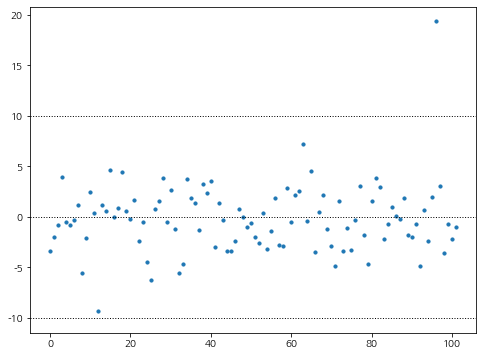

In [215]:
plt.figure(figsize=(8,6))
plt.scatter(range(pred_lr.size), y_test - pred_lr, s = 10)
plt.axline((0,10),(1,10), color='k', linewidth=1, linestyle=':')
plt.axline((0,-10),(1,-10), color='k', linewidth=1, linestyle=':')
plt.axline((0,0),(1,0), color='k', linewidth=1, linestyle=':')
plt.show()

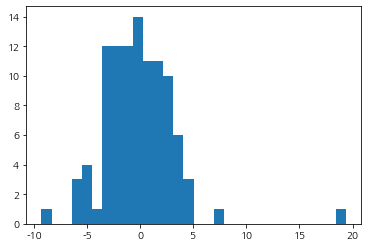

In [222]:
plt.hist(y_test - pred_lr, bins=30)
plt.show()

In [221]:
shapiro(y_test - pred_lr)

ShapiroResult(statistic=0.8860327005386353, pvalue=2.650097314926825e-07)

# Train: Random Forest

In [6]:
model = RandomForestRegressor(random_state=42)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns = feature_names), pd.Series(y, name='label'), test_size = .2, random_state=42)

In [283]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [284]:
rfe = RFECV(estimator=model_lr, cv=5, scoring='neg_mean_absolute_error')

X_train = rfe.fit_transform(X_train, y_train)
X_test = rfe.transform(X_test)

In [287]:
rfe.ranking_

array([1, 3, 4, 2, 1, 1, 5, 1, 1, 1, 1, 1, 1])

In [285]:
pf = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)

X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

In [8]:
model.fit(X_train, y_train)

model.score(X_test, y_test, )

0.8922527442109116

In [42]:
rfe = RFECV(estimator=model, cv=5, scoring='r2')
sfm = SelectFromModel(estimator=model, threshold='median')
sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=7, scoring='r2')

In [43]:
rfe.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestRegressor(random_state=42), scoring='r2')

In [44]:
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

In [46]:
X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

## Recursive Feature Elimination

In [10]:
rfe = RFE(estimator=model, )

In [11]:
rfe.fit(X_train, y_train)

rfe.ranking_

array([1, 7, 5, 8, 2, 1, 3, 1, 6, 1, 1, 4, 1])

In [12]:
model.feature_importances_

array([0.03806177, 0.00175615, 0.00795268, 0.00100426, 0.01554377,
       0.50384493, 0.01383994, 0.06054907, 0.00381091, 0.01566064,
       0.01631341, 0.01215362, 0.30950883])

In [13]:
np.argsort(model.feature_importances_)

array([ 3,  1,  8,  2, 11,  6,  4,  9, 10,  0,  7, 12,  5], dtype=int64)

In [17]:
result = np.zeros(feature_names.size)
rk = np.argsort(model.feature_importances_)
ch = int(feature_names.size/2)
result[rk[-ch:]] = 1

result[rk[:-ch]] = np.arange(feature_names.size - ch +1, 1, -1)

In [19]:
np.alltrue(result == rfe.ranking_)

True